First, we need to increase the timeout time so that the loading of data occurs correctly.

In [1]:
from astropy.utils.data import conf
conf.dataurl

'http://data.astropy.org/'

In [2]:
conf.remote_timeout

10.0

In [3]:
conf.remote_timeout = 10000

In [4]:
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy import time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import Sun, Earth, Moon, Mars
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.util import time_range
from poliastro import iod
from poliastro.maneuver import Maneuver

import numpy as np

EPOCH = Time("2020-11-01 12:05:50", scale="tdb")
C_FLORENCE = "#000"
C_MOON = "#999"

In [6]:
themis_osc = Orbit.from_sbdb("Themis")
themis_osc

3 x 4 AU x 0.8 deg (HeliocentricEclipticIAU76) orbit around Sun (☉) at epoch 2459200.500800735 (TDB)

In [7]:
themis_osc.epoch.iso

'2020-12-17 00:01:09.183'

In [8]:
from poliastro.ephem import Ephem

In [9]:
epochs = time_range(
    EPOCH - TimeDelta(3 * 30 * u.day), end=EPOCH + TimeDelta(90 * 30 * u.day)
)

In [10]:
themis = Ephem.from_horizons("Themis", epochs, plane=Planes.EARTH_ECLIPTIC)
themis

Ephemerides at 50 epochs from 2020-08-03 12:05:50.000 (TDB) to 2028-03-24 12:05:50.000 (TDB)

In [11]:
themis.plane

<Planes.EARTH_ECLIPTIC: 'Earth mean Ecliptic and Equinox of epoch (J2000.0)'>

In [12]:
earth = Ephem.from_body(Earth, epochs, plane=Planes.EARTH_ECLIPTIC)
earth

Ephemerides at 50 epochs from 2020-08-03 12:05:50.000 (TDB) to 2028-03-24 12:05:50.000 (TDB)

In [13]:
from poliastro.util import norm

In [14]:
min_distance = norm(themis.rv(EPOCH)[0] - earth.rv(EPOCH)[0]) - Earth.R
min_distance.to(u.km)

<Quantity 6.10816163e+08 km>

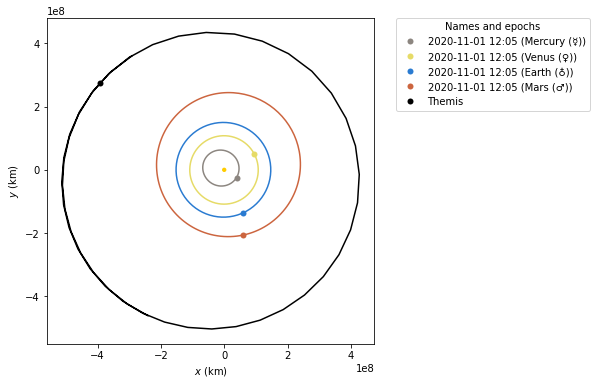

In [16]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot_ephem(themis, EPOCH, label="Themis", color=C_FLORENCE);

In [22]:
import numpy as np

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.util import norm, time_range

All data for the USP mission is sorted here. The main maneuvers the spacecraft will perform are listed below:

- Inner Cruise Phase 1: This will put the USP into a new orbit around the Sun.
- Inner Cruise Phase 2: Fly around the Earth. Gravity assist is performed.
- Inner Cruise Phase 3: Themis insertion maneuver.

In [23]:
date_launch = Time("2027-01-13 16:25", scale="utc").tdb
date_flyby = Time("2029-01-01 19:21", scale="utc").tdb
date_arrival = Time("2032-12-05 03:18", scale="utc").tdb

# Atlas V supplied a launch energy
C_3 = 31.1 * u.km ** 2 / u.s ** 2

c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
c:\users\disser\appdata\local\programs\python\python39\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


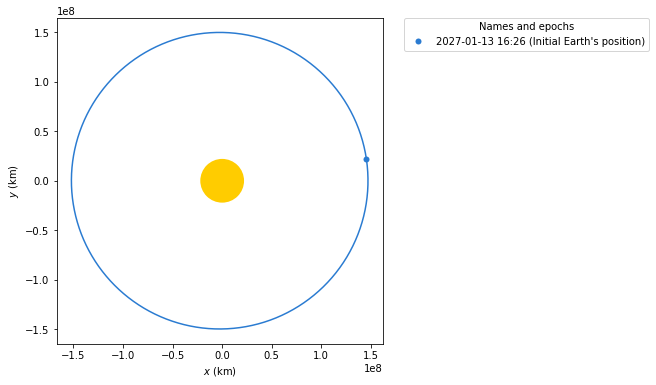

In [24]:
# Plot initial Earth's position
Earth.plot(date_launch, label="Initial Earth's position");

In [25]:
earth = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival, periods=1000))

r_e0, v_e0 = earth.rv(date_launch)

# Assume that the insertion velocity is tangential to that of the Earth
dv = C_3 ** 0.5 * v_e0 / norm(v_e0)

# We create the maneuver from impulse constructor
man = Maneuver.impulse(dv)

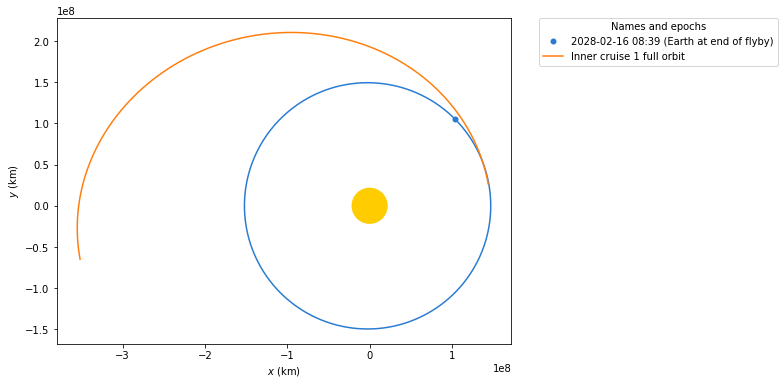

In [26]:
ss_e0 = Orbit.from_ephem(Sun, earth, date_launch)
ss_efly = Orbit.from_ephem(Sun, earth, date_flyby)

# Inner Cruise 1
ic1 = ss_e0.apply_maneuver(man)
ic1_end = ic1.propagate_to_anomaly(180 * u.deg)

# We solve for Earth's position when Juno is at aphelion
ss_e_ic1 = Orbit.from_ephem(Sun, earth, epoch=ic1_end.epoch)

# We can check new bodies positions
plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(Earth, ic1_end.epoch, label="Earth at end of flyby")
plotter.plot_trajectory(
    ic1_end.sample(min_anomaly=0 * u.deg, max_anomaly=180 * u.deg),
    label="Inner cruise 1 full orbit",
    color="C1",
);

We can verify that the orbital period is the same as that given in the mission documentation. Remember, in the previous plot, we only laid down half an orbit for the first USP maneuver, and the period is the time it would take the USP to make one complete revolution around this new orbit.

In [27]:
ic1.period.to(u.day)

<Quantity 798.96125777 d>

Note in the previous plot that the position of the Earth is not the initial position, since the Earth is also moving while the USP is moving. Now we decide for Lambert's maneuver to make a flyby around the Earth when it is at the moment of flyby.

In [28]:
# Let's compute the Lambert solution to do the flyby of the Earth
man_flyby = Maneuver.lambert(ic1_end, ss_efly)
imp_a, imp_b = man_flyby.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)

Initial impulse: (<Quantity 0. s>, <Quantity [-1388.48132264,  3376.49390631,  1459.05091235] m / s>)
Final impulse: (<Quantity 27686548.63342208 s>, <Quantity [5989.42355337, -731.01062802, -326.83512643] m / s>)


In [29]:
# Check the initial delta-V
dv_a = imp_a[-1]
norm(dv_a.to(u.km / u.s))

<Quantity 3.93159269 km / s>

Now we can decide on an orbit, which will help the USP with gravitational assistance. Again, the internal pahse 2 maneuver is determined until the USP reaches the Earth's position on the flyby date, although the full orbit is mapped.

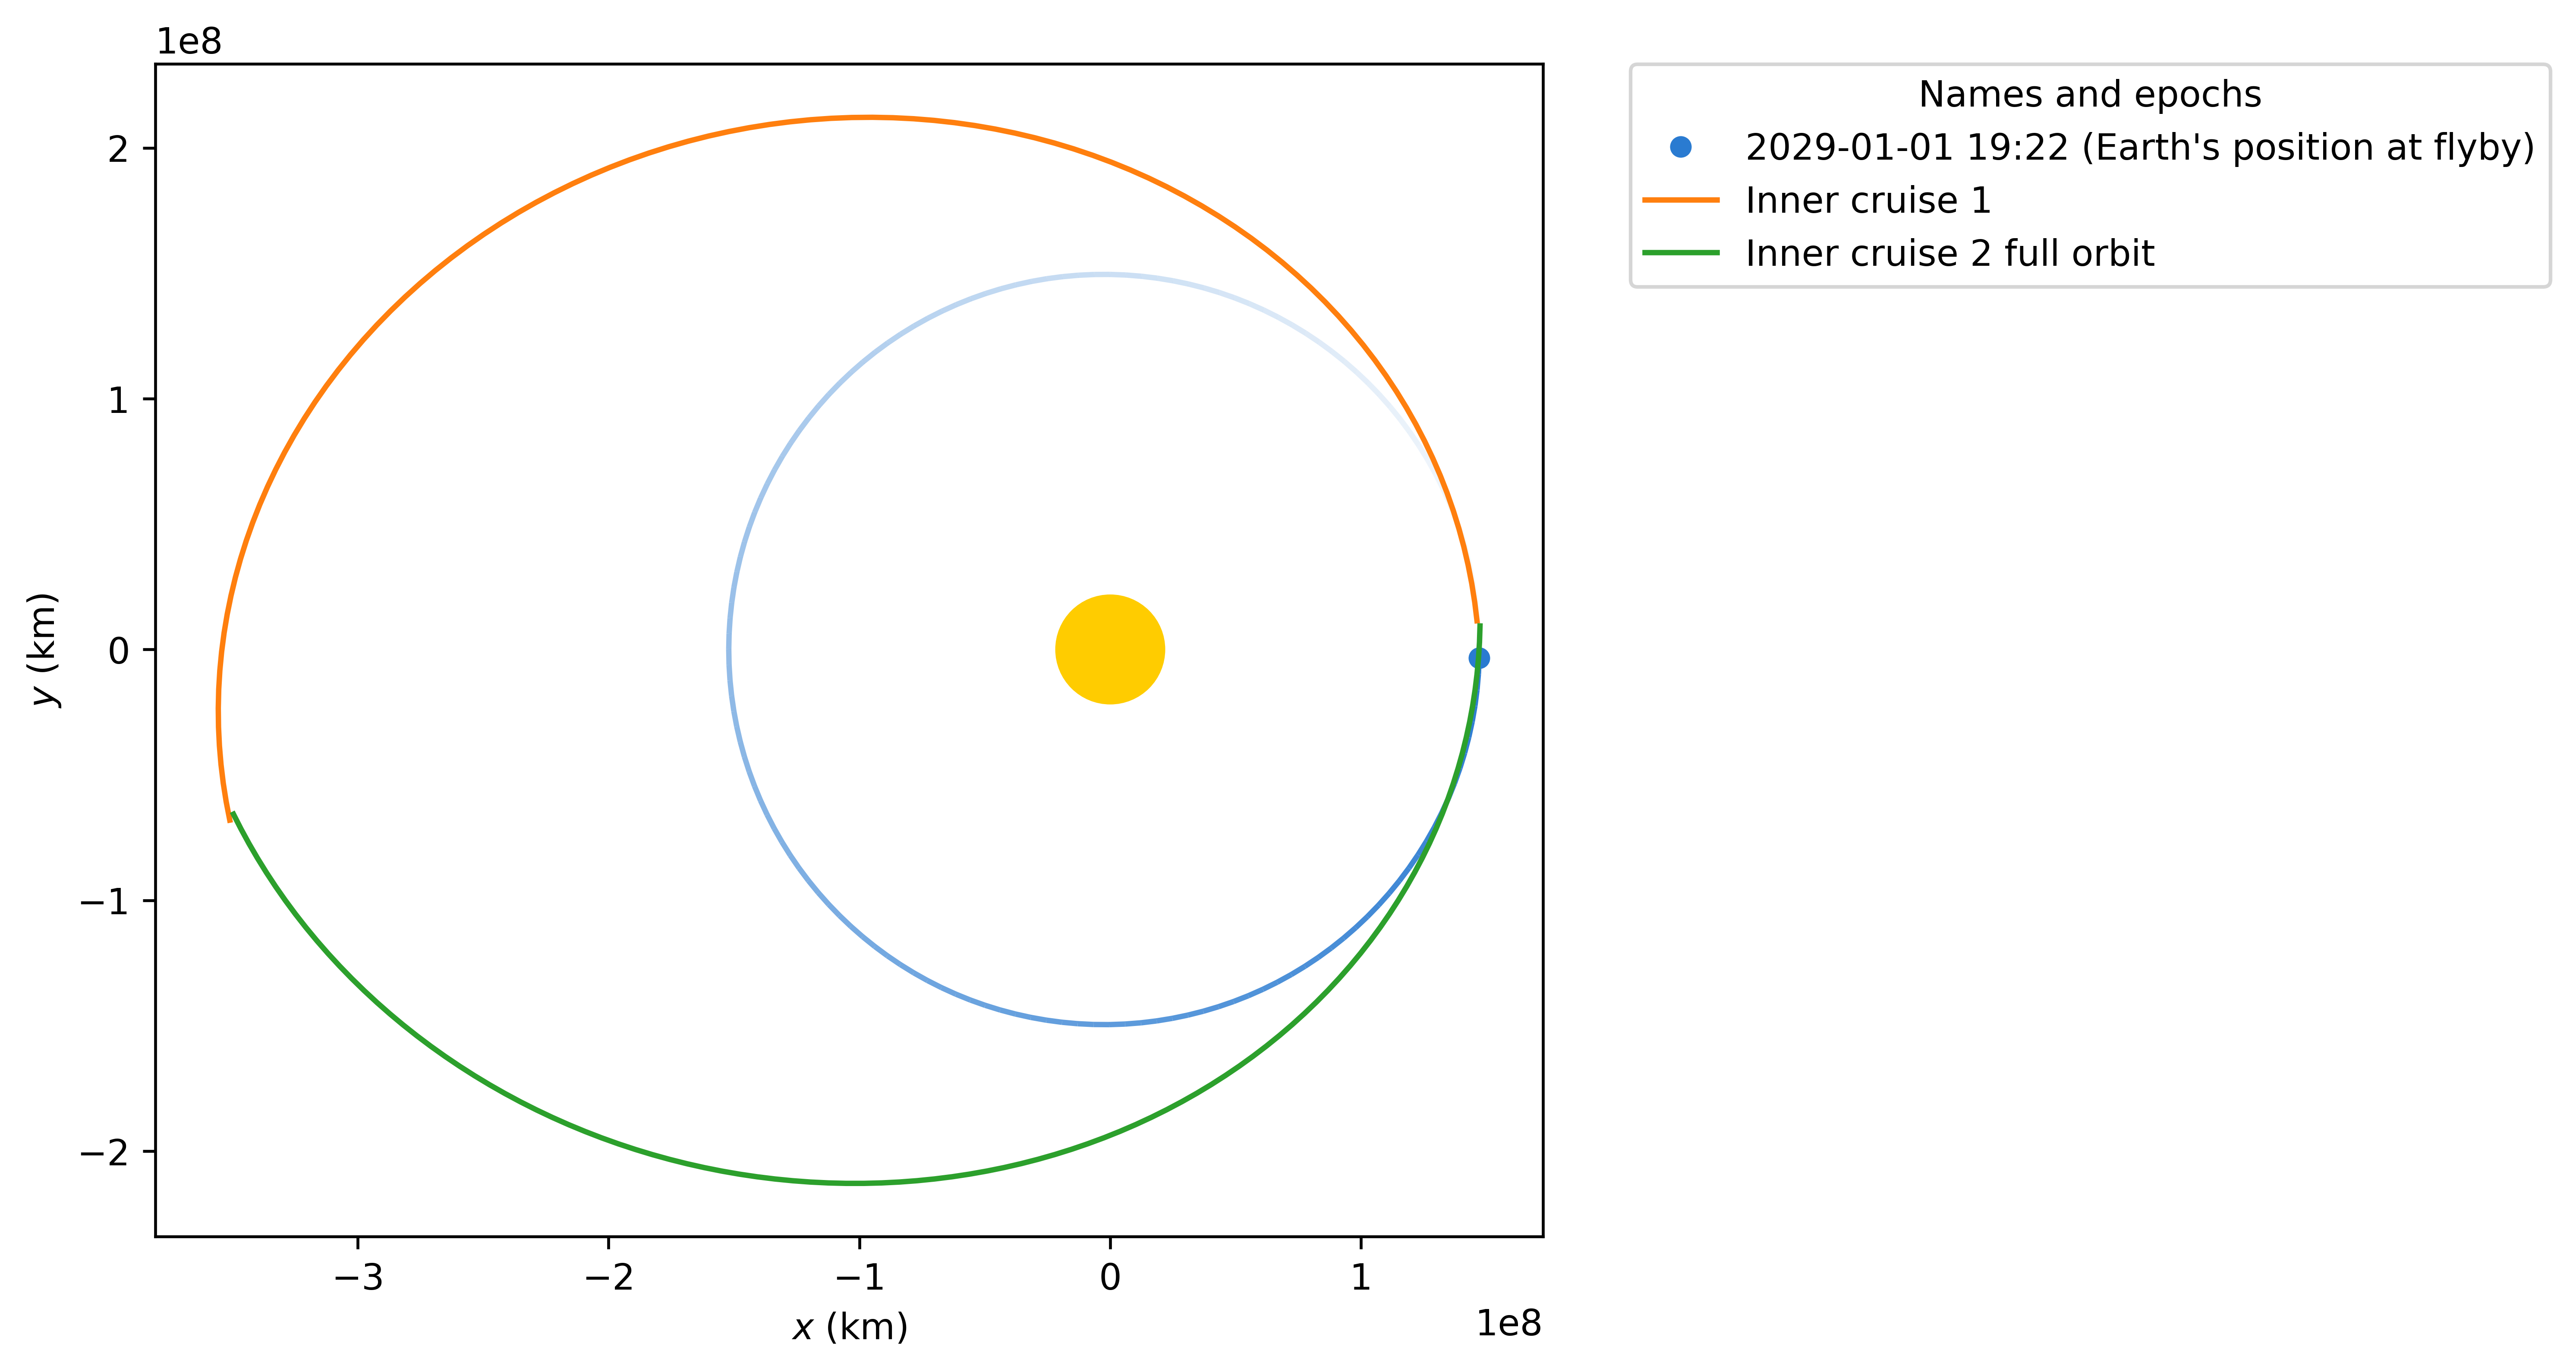

In [38]:
# Let us apply the maneuver
ic2, ss_flyby = ic1_end.apply_maneuver(man_flyby, intermediate=True)

# We propagate the transfer orbit till the flyby occurs
ic2_end = ic2.propagate(date_flyby)

plotter = StaticOrbitPlotter()
plotter.plot_body_orbit(
    Earth,
    ss_efly.epoch,
    label="Earth's position at flyby",
    trail=True,
)
plotter.plot_trajectory(
    ic1.sample(min_anomaly=-5* u.deg, max_anomaly=181.5 * u.deg), label="Inner cruise 1", color="C1"
)
plotter.plot_trajectory(
    ic2_end.sample(min_anomaly=-158 * u.deg, max_anomaly=15 * u.deg),
    label="Inner cruise 2 full orbit",
    color="C2",
);

Now we can begin our search for someone to take the USP to Themis. Another Lambert maneuver is required, but first let us deal with Themis' position on arrival.

In [31]:
Themis = Ephem.from_horizons("Themis", time_range(date_launch, end=date_arrival), plane=Planes.EARTH_EQUATOR)

ss_j = Orbit.from_ephem(Sun, Themis, date_arrival)

In [32]:
# Solving for maneuver to Themis
man_themis = Maneuver.lambert(ic2_end, ss_j)
imp_a, imp_b = man_themis.impulses

print("Initial impulse:", imp_a)
print("Final impulse:", imp_b)

Initial impulse: (<Quantity 0. s>, <Quantity [-2885.83797704,   994.24317737,  1903.22317027] m / s>)
Final impulse: (<Quantity 1.2383982e+08 s>, <Quantity [ 8994.80057429, -5832.84933837, -2291.57622976] m / s>)


Again, we apply the maneuver.

In [33]:
# Apply the maneuver
ic3, ss_target = ic2_end.apply_maneuver(man_themis, intermediate=True)
ic3_end = ic3.propagate(date_arrival)

In [34]:
dv_a = imp_a[-1]
dv_b = imp_b[-1]
dv_sum = dv_a + dv_b
totalDV = format(norm(dv_sum.to(u.m / u.s)), ".3f")

Finally, we can outline all the different stages of the mission.

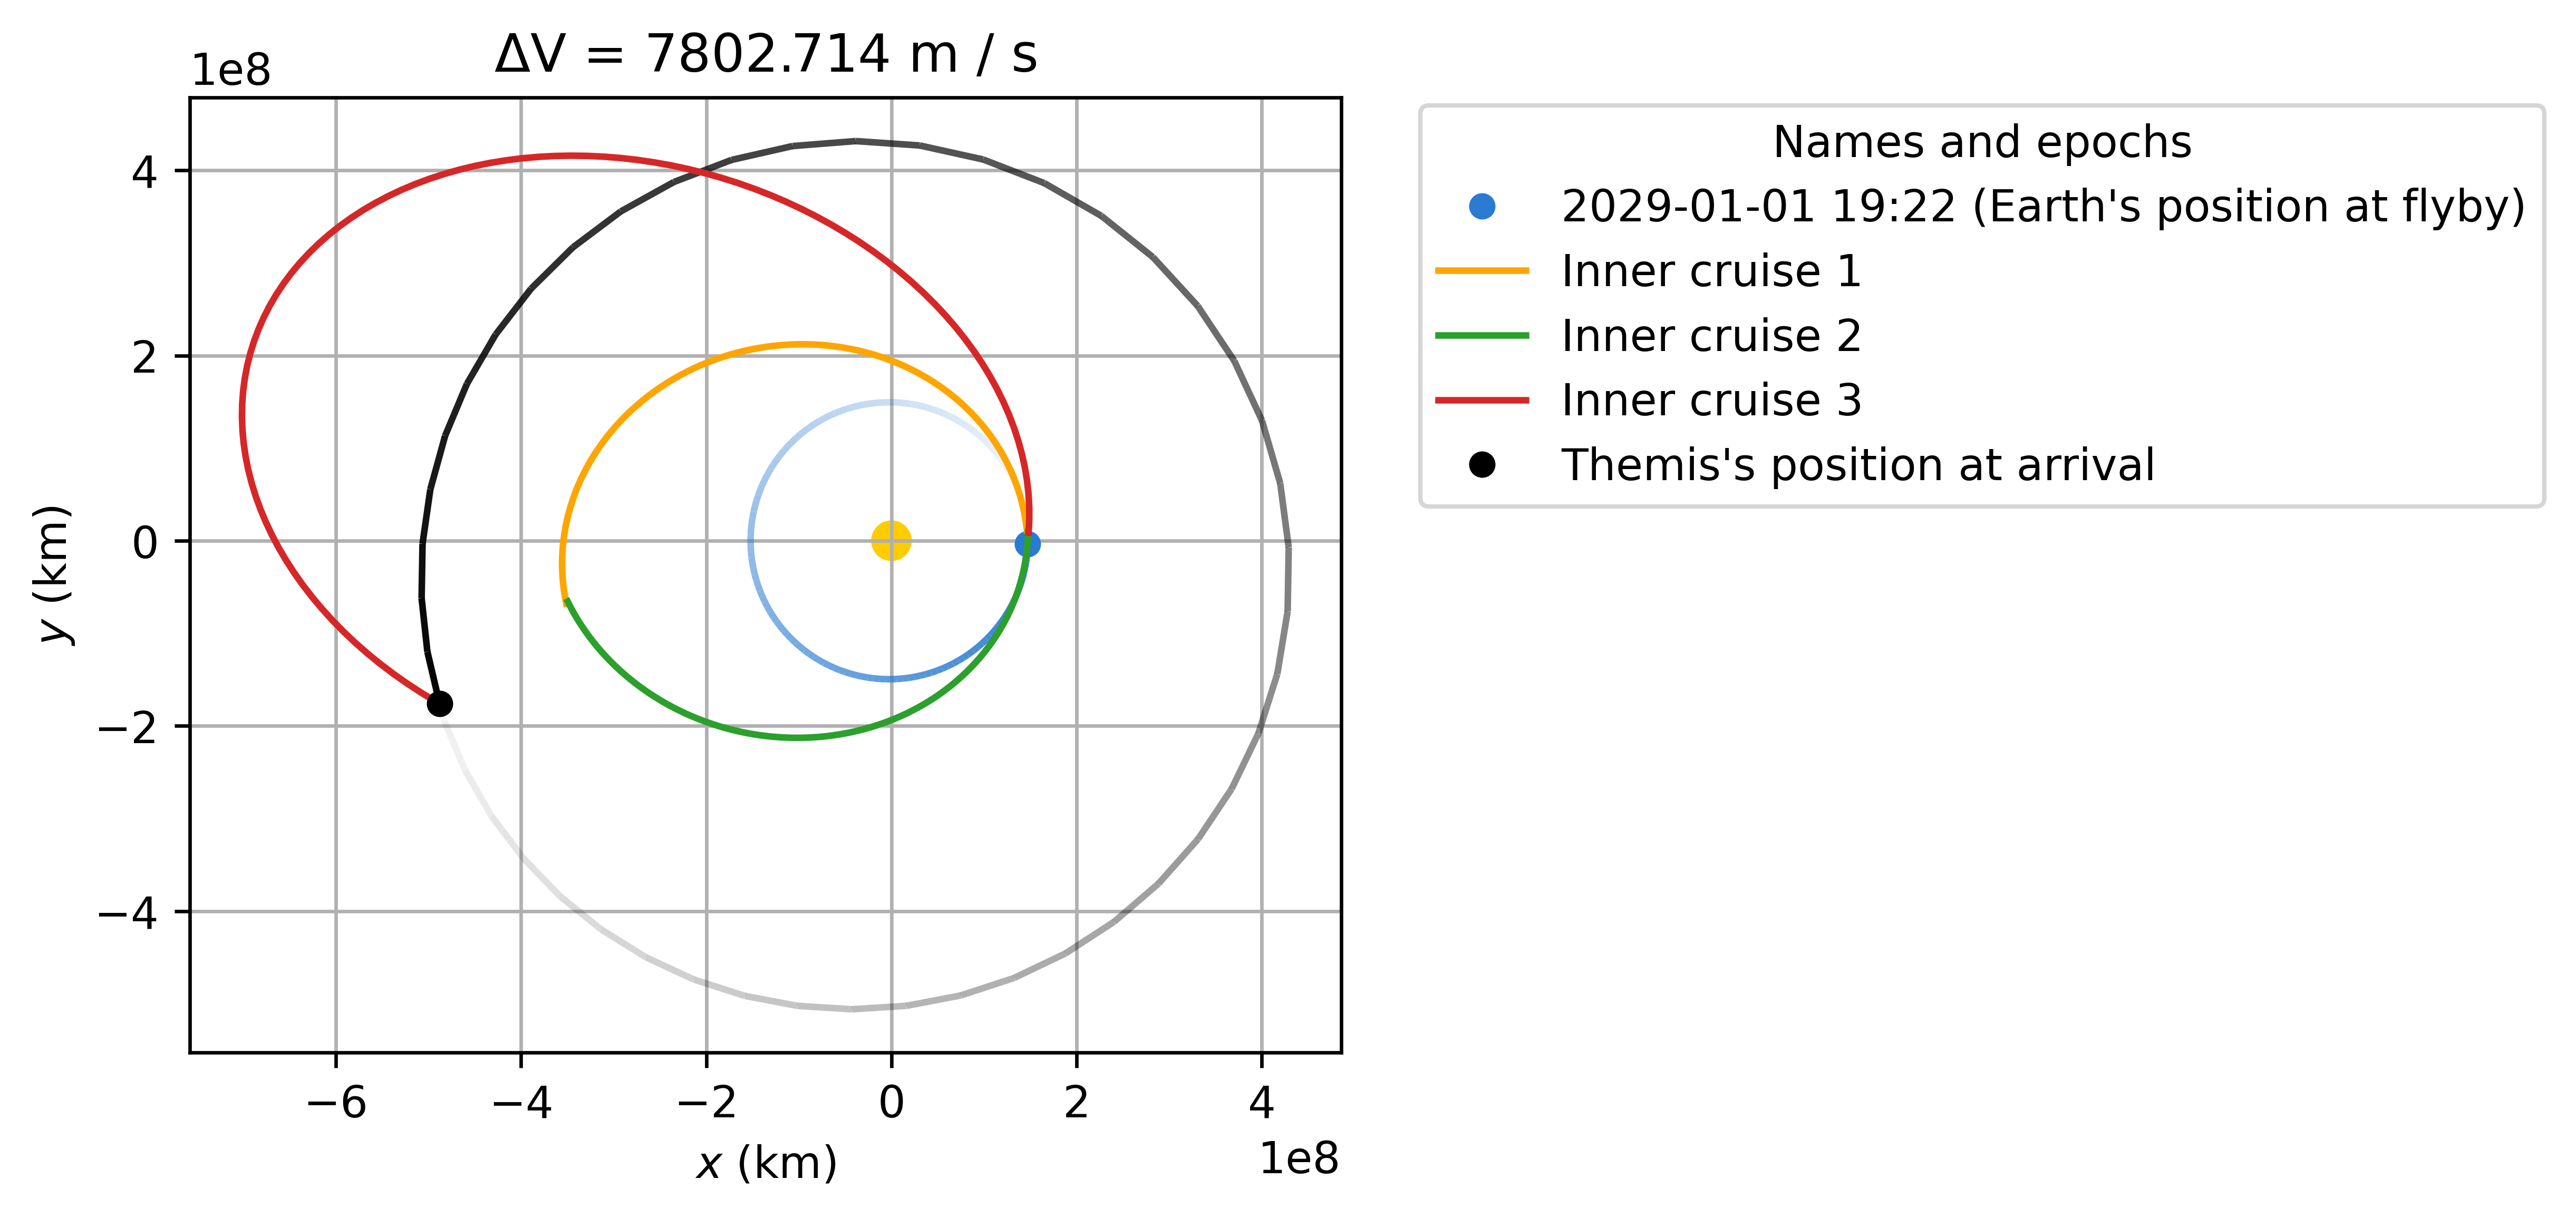

In [35]:
# Final plot for the whole mission
plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots()

ax.grid(True)
ax.set_title(r'$\Delta$' + 'V = ' + totalDV)
ax.set_facecolor("None")

plotter = StaticOrbitPlotter(ax)

plotter.plot_body_orbit(
    Earth,
    date_flyby,
    label="Earth's position at flyby",
    trail=True,
)

plotter.plot_trajectory(
    ic1.sample(min_anomaly=-5* u.deg, max_anomaly=181.5 * u.deg), label="Inner cruise 1", color="orange"
)

plotter.plot_trajectory(
    ic2.sample(min_anomaly=-158* u.deg, max_anomaly=15 * u.deg),
    label="Inner cruise 2",
    color="C2",
)

plotter.plot_trajectory(
    ic3.sample(min_anomaly=20 * u.deg, max_anomaly=216 * u.deg),
    label="Inner cruise 3",
    color="C3",
)
#plotter.plot_body_orbit(Themis, date_arrival, label="Jupiter's position at arrival", trail=True);

plotter.plot_ephem(Themis, date_arrival, label="Themis's position at arrival", color=C_FLORENCE, trail=True);
#plotter._set_legend(, 3)
